# (실습-1) ViT 구현 실습

## 실습 개요

1) 실습 목적

이 실습에서는 CIFAR10 데이터셋을 이용하여 Multi-class classification을 수행하는 Vision Transformer (ViT) 모델을 PyTorch로 직접 구현하게 됩니다. Vision Transformer는 자연어 처리 분야에서 탁월한 성능을 보여준 Transformer 아키텍처를 이미지 분류에 적용한 모델입니다. 이 강의를 통해 ViT 모델의 작동 원리와 PyTorch 프레임워크를 이용한 모델 구현 및 학습 방법에 대해 학습하게 됩니다.


 2) 수강 목표
- 목표 1: Vision Transformer의 주요 구성 요소와 작동 원리에 대한 이해
- 목표 2: 학습 프로세스에 대한 이해

    1) 데이터 전처리: CIFAR10 데이터셋을 불러오고, 전처리하여 ViT 학습에 적합한 형태로 변환하기
    
    2) 모델 구성: PyTorch를 활용하여 ViT 모델 구조를 직접 구현하고, 모델의 파라미터를 초기화하기
    
    3) 학습 프로세스: Optimizer 설정 및 학습 루프를 통해 모델을 CIFAR10 데이터셋에 학습시키기
    
    4) 성능 평가: 학습된 모델을 테스트셋에 대해 평가하고, 분류 정확도 및 오차를 분석하기
- 목표 3: ViT 학습에 있어 중요한 하이퍼파라미터와 튜닝 방법에 대한 인사이트 얻기

### 실습 목차
- 목차 1
    - 1-1 : ViT를 encoder로 하는 classification model 정의
    - 1-2 : ViT 모델 정의 및 forward 함수 제작
    - 1-3 : ViT encoder의 hyper parameter 세팅을 위한 함수 정의
- 목차 2
    - 2-1 : 이미지 patch에 대한 이해 및 구현
    - 2-2 : Self-attention mechanism에 대한 이해 및 구현
    - 2-3 : Transformer구조의 Encoder block에 대한 이해 및 구현 (+drop path, feed forward)
- 목차 3
    - 3-1 : 데이터 로드 및 전처리
    - 3-2 : 학습을 위한 모델 및 목적함수, 옵티마이저 정의
    - 3-3 : 모델 학습 (Training)
    - 3-4 : 학습한 모델 평가 (Test and Evaluation)


### 데이터셋 개요
CIFAR-10은 이미지 분류를 위한 대표적인 벤치마크 데이터셋 중 하나로, 총 60,000개의 32x32 픽셀 크기의 컬러 이미지로 구성되어 있다. 이 중 50,000개는 훈련 데이터로, 나머지 10,000개는 테스트 데이터로 사용된다. 데이터셋은 10개의 다른 클래스로 구성되어 있으며, 각 카테고리마다 6,000개의 이미지가 있다.

### 환경 설정


In [ ]:
# HuggingFace에서 제공하는 ViT 모델을 불러오기 위한 패키지 설치
!pip install transformers

In [ ]:
# DINO pre-trained model, embedding=384, num_head=16
!wget https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth

In [ ]:
import os
import math
import argparse
from functools import partial

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.nn.init import trunc_normal_
from transformers import ViTForImageClassification

## 목차 1
- 1-1 : ViT를 encoder로 하는 classification model 정의
- 1-2 : ViT 모델 정의 및 forward 함수 제작
- 1-3 : ViT encoder의 hyper-parameter 세팅을 위한 함수 정의

#### 📝 설명 : (1-1)
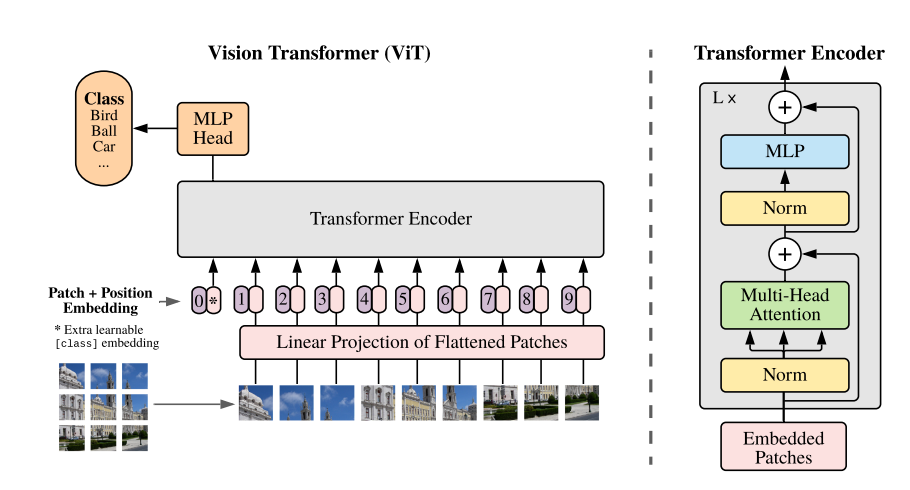
*  Vision Transformer의 전체 pipeline
    * 이미지 분할 (image patching): 입력 이미지를 고정된 크기의 패치들로 분할
        * Ex) 224x224 이미지를 16x16 패치로 분할하면 14x14=196개의 패치가 생김
    * Patch Embedding: 각 패치를 벡터로 변환
        * Linear projection(선형 투영)을 사용하여 임베딩된 공간으로 변환

    * Positional Embedding: 각 패치 임베딩에 위치 정보를 추가하여 Transformer가 패치의 위치를 알 수 있게 함

    * Transformer 인코더:
        * 패치 임베딩을 Transformer 인코더에 통과시켜 정보를 통합
    * 클래스 토큰 추가:
        * 시작 부분에 특별한 [CLS]와 같은 클래스 토큰 추가
        * 이 토큰은 이미지의 최종 분류 결과를 나타냄
    * Feed Forward Network:
        * Transformer 출력의 클래스 토큰을 다중 레이어 퍼셉트론(MLP) 헤드에 통과시켜 최종 분류 결과를 얻음

#### 👨‍💻 코드 : (1-1)

In [ ]:
class VisionTransformerWithLinear(nn.Module):
    def __init__(self, base_vit, embed_dim=384, num_classes=10, **kwargs):
        """Vision Transformer with an additional Linear Classifier.

        Args:
            base_vit (nn.Module): 기존 Vision Transformer 모델.
            embed_dim (int, optional): 임베딩 차원의 크기. 기본값은 384.
            num_classes (int, optional): 출력 클래스의 개수. 기본값은 10.

        """

        super().__init__()
        self.base_vit = base_vit

        # ViT encoder로부터 얻어진 잠재적 특징 맵을 분류를 위한 최종 출력으로 투영
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        """Forward pass를 위한 함수.

        Args:
            x (torch.Tensor): 입력 이미지.

        Returns:
            torch.Tensor: 분류기의 로짓 결과.
        """

        # 이미지를 인코더로 입력
        features = self.base_vit(x)

        # 인코더의 출력을 정규화
        features = torch.nn.functional.normalize(features, dim=-1)

        # 분류 헤드를 거쳐 최종 로짓을 계산
        logits = self.fc(features)

        return logits

#### 📝 설명 : (1-2)

*  Positional Embedding과  Class token
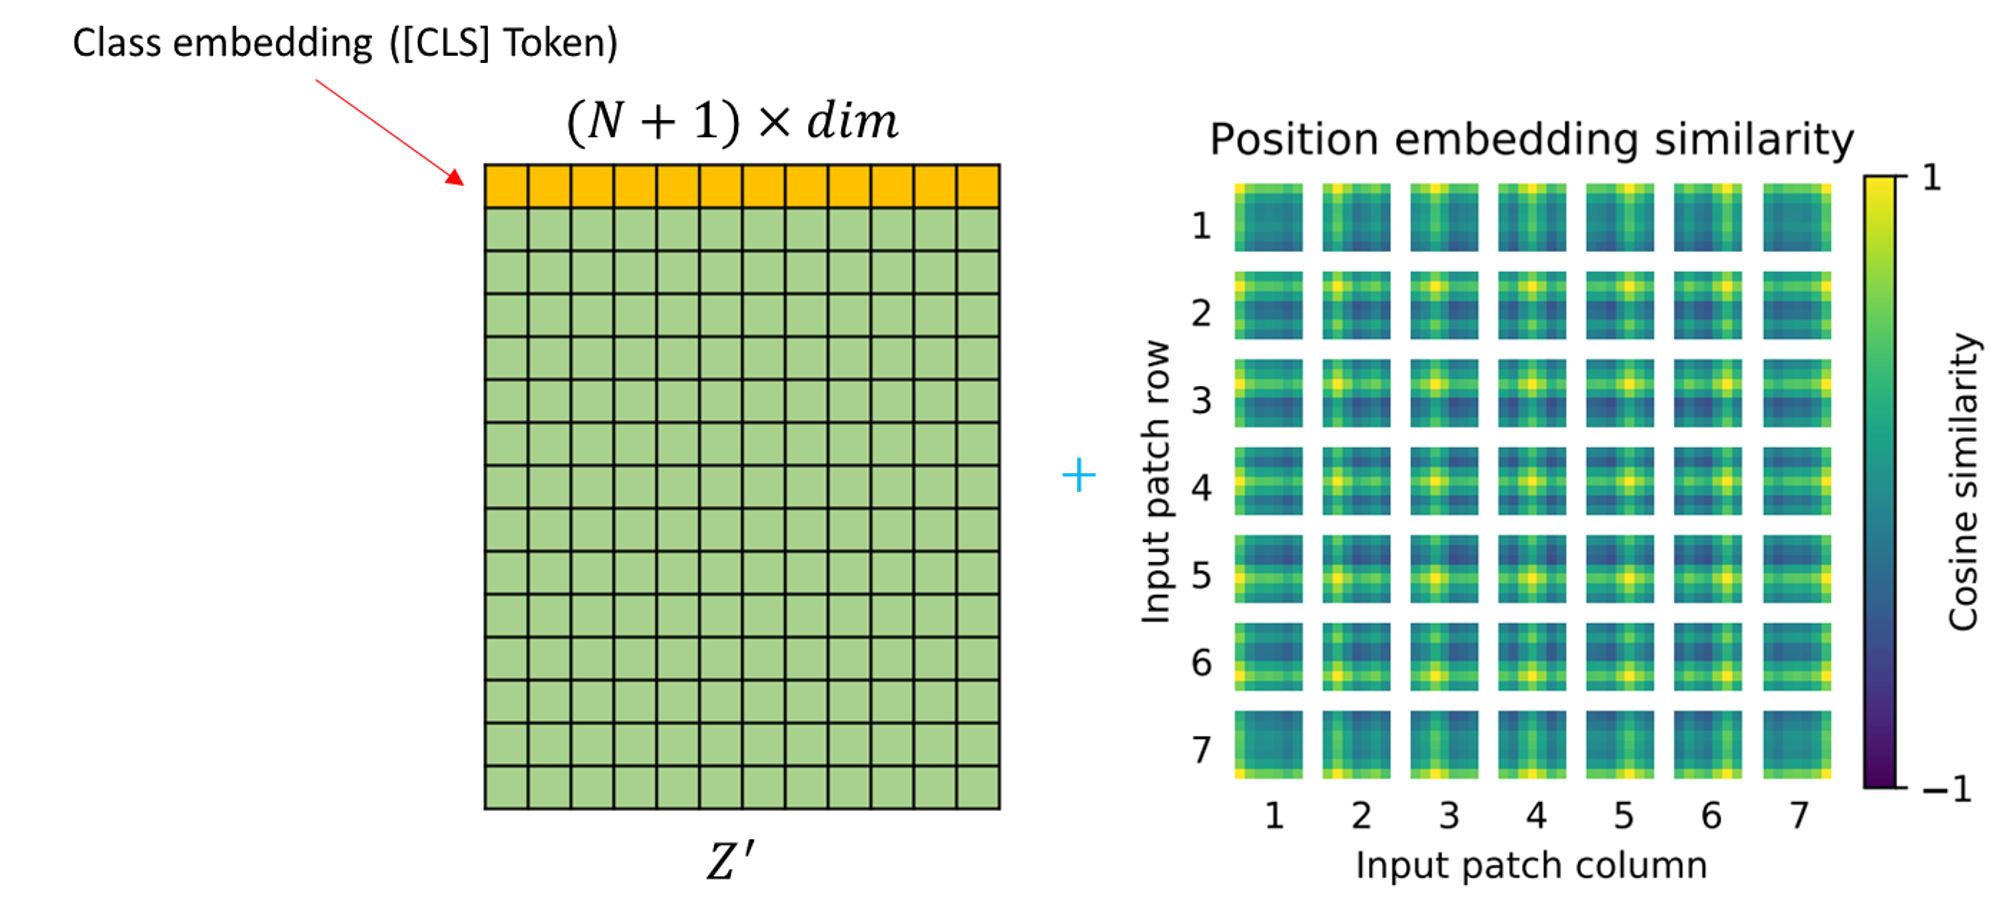

#### 👨‍💻 코드 : (1-2)

In [ ]:
class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(
            self,
            img_size=[224],
            patch_size=16,
            in_chans=3,
            num_classes=0,
            embed_dim=768,
            depth=12,
            num_heads=12,
            mlp_ratio=4.,
            drop_rate=0.,
            attn_drop_rate=0.,
            drop_path_rate=0.,
            norm_layer=nn.LayerNorm,
            **kwargs
        ):
        """
        Args:
            img_size: 이미지 크기.
                정사각형으로 resize된 이미지가 사용되기 때문에, 가로 또는 세로 크기 하나만 입력.
            mlp_ratio: Transformer의 feed forward 부분의 hidden dimension을 결정.
                hidden_dim = embedding_size * mlp_ratio
            drop_path_rate: Dropout과 같이 과적합을 막기위함.
              Transformer encoder의 skip connection 부분에서 새로운 value vector를 랜덤하게 제거.
        """

        super().__init__()

        # Embedding size
        self.embed_dim = embed_dim

        # From image to patch
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)

        # 인풋 image와 patch 크기로부터 계산된 patch 갯수 (224/16 = 14 -> 가로, 세로 14개씩 patch로 총 196개의 patch가 생성)
        num_patches = self.patch_embed.num_patches

        # CLS Token 생성, 학습가능한 파라미터로 설정 (1개 patch)
        # 일단 batch size를 1로 설정 후 이후에 batch size에 맞게 broadcast
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embedding 생성, 학습가능한 파라미터 설정 (각 patch + class token)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # Postional embedidng 결과에 dropout을 적용하기 위함
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Drop 확률을 depth에 따라 차등적용
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        # Attention blocks
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])

        self.norm = norm_layer(embed_dim)

        # Class token과 positional embedding의 parameter 초기화
        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)

        # Layernorm과 classification head의 parameter 초기화
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Layernorm과 classification head의 parameter 초기화하는 함수"""

        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        """Pre-trained된 positional encoding을 interpolation을 사용하여 고해상도 이미지에 적용하기 위한 함수"""

        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1

        # Interpolation 할 필요가 없으면 interpoltation 없이 postional embedding 적용
        if npatch == N and w == h:
            return self.pos_embed

        # Interpolation을 위한 코드
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x, interpolate_pos_encoding=False):
        """이미지 embedding후 classification token과 positional embedding을 추가로 적용하는 함수"""

        # (batch, number of channel, width, height)
        B, nc, w, h = x.shape

        # 이미지를 토큰화후 embedding
        x = self.patch_embed(x)  # patch linear embedding

       # [CLS] 토큰을 batch size에 맞게 확장
        cls_tokens = self.cls_token.expand(B, -1, -1)

        # [CLS] 토큰을 embedding patch에 추가
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        # positional embedding 결과에 dropout 적용
        x = self.pos_drop(x)

        return x

    def forward(self, x, return_all_patches=False):
        # 이미지 -> token -> embedding
        x = self.prepare_tokens(x)

        # 정해진 depth만큼 encoder block 적용
        for blk in self.blocks:
            x = blk(x)

        # encoder output을 normalization
        x = self.norm(x)

        # 학습된 모든 patch가 필요한 경우 모든 patch의 latent feature map을 반환
        if return_all_patches:
            return x
        # CLS Token의 latent feature map만 반환
        else:
            return x[:, 0]

#### 👨‍💻 코드 : (1-3)

In [ ]:
def vit_small(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size,
        embed_dim=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs
    )
    return model

def vit_base(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs
    )
    return model

## 목차 2
- 2-1 : 이미지 patch에 대한 이해 및 구현
- 2-2 : Self-attention mechanism에 대한 이해 및 구현
- 2-3 : Transformer구조의 Encoder block에 대한 이해 및 구현 (+Drop path, feed forward)

#### 📝 설명 : (2-1)
*  Image patching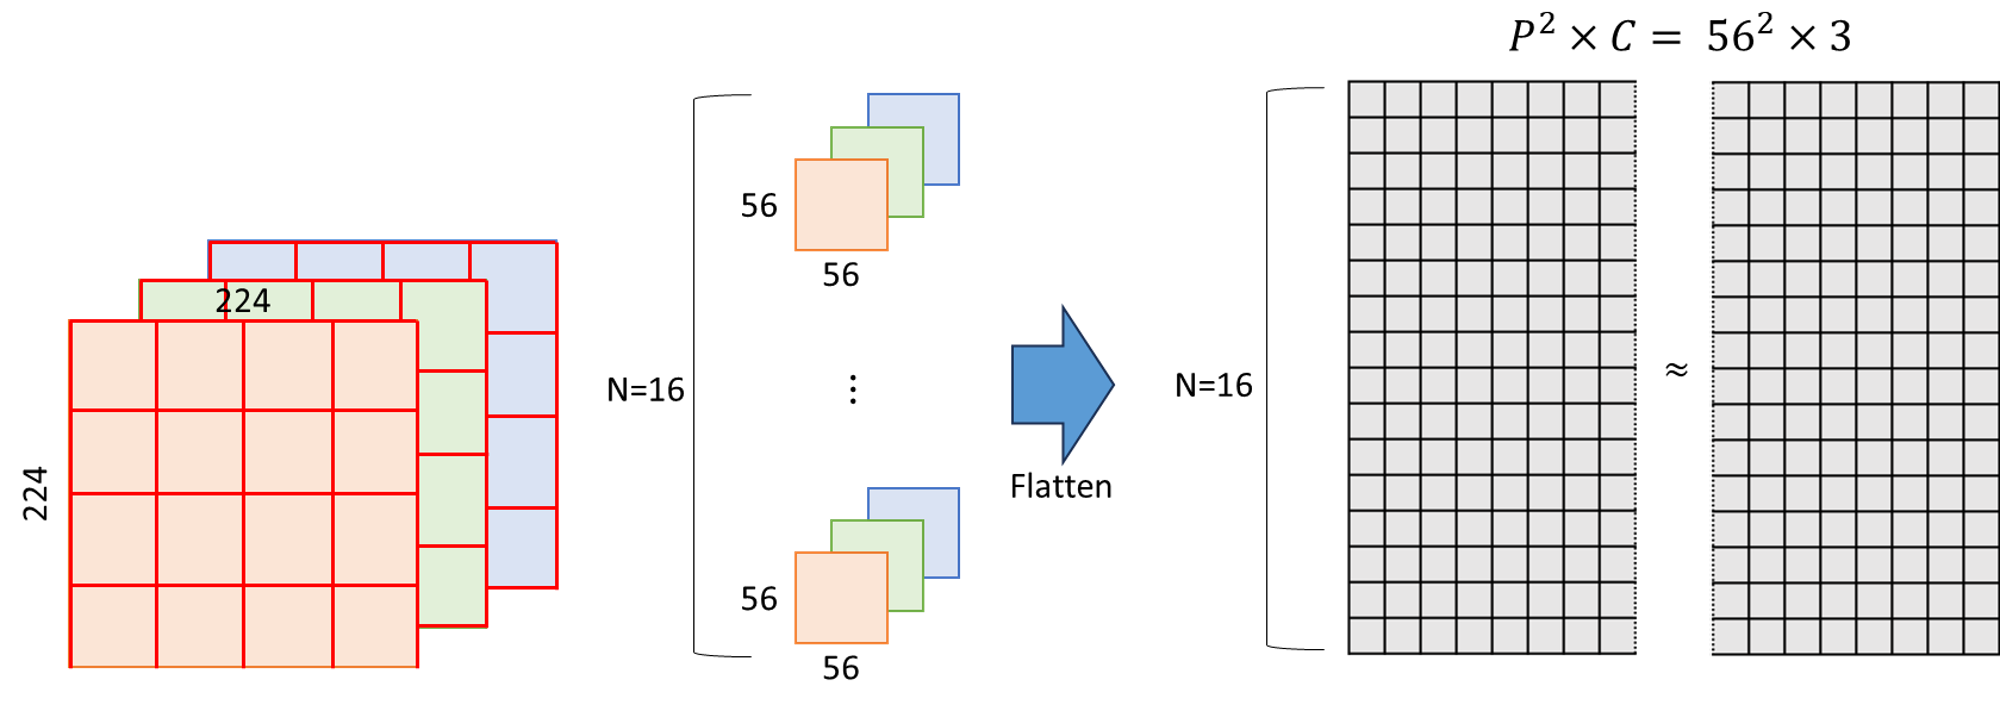
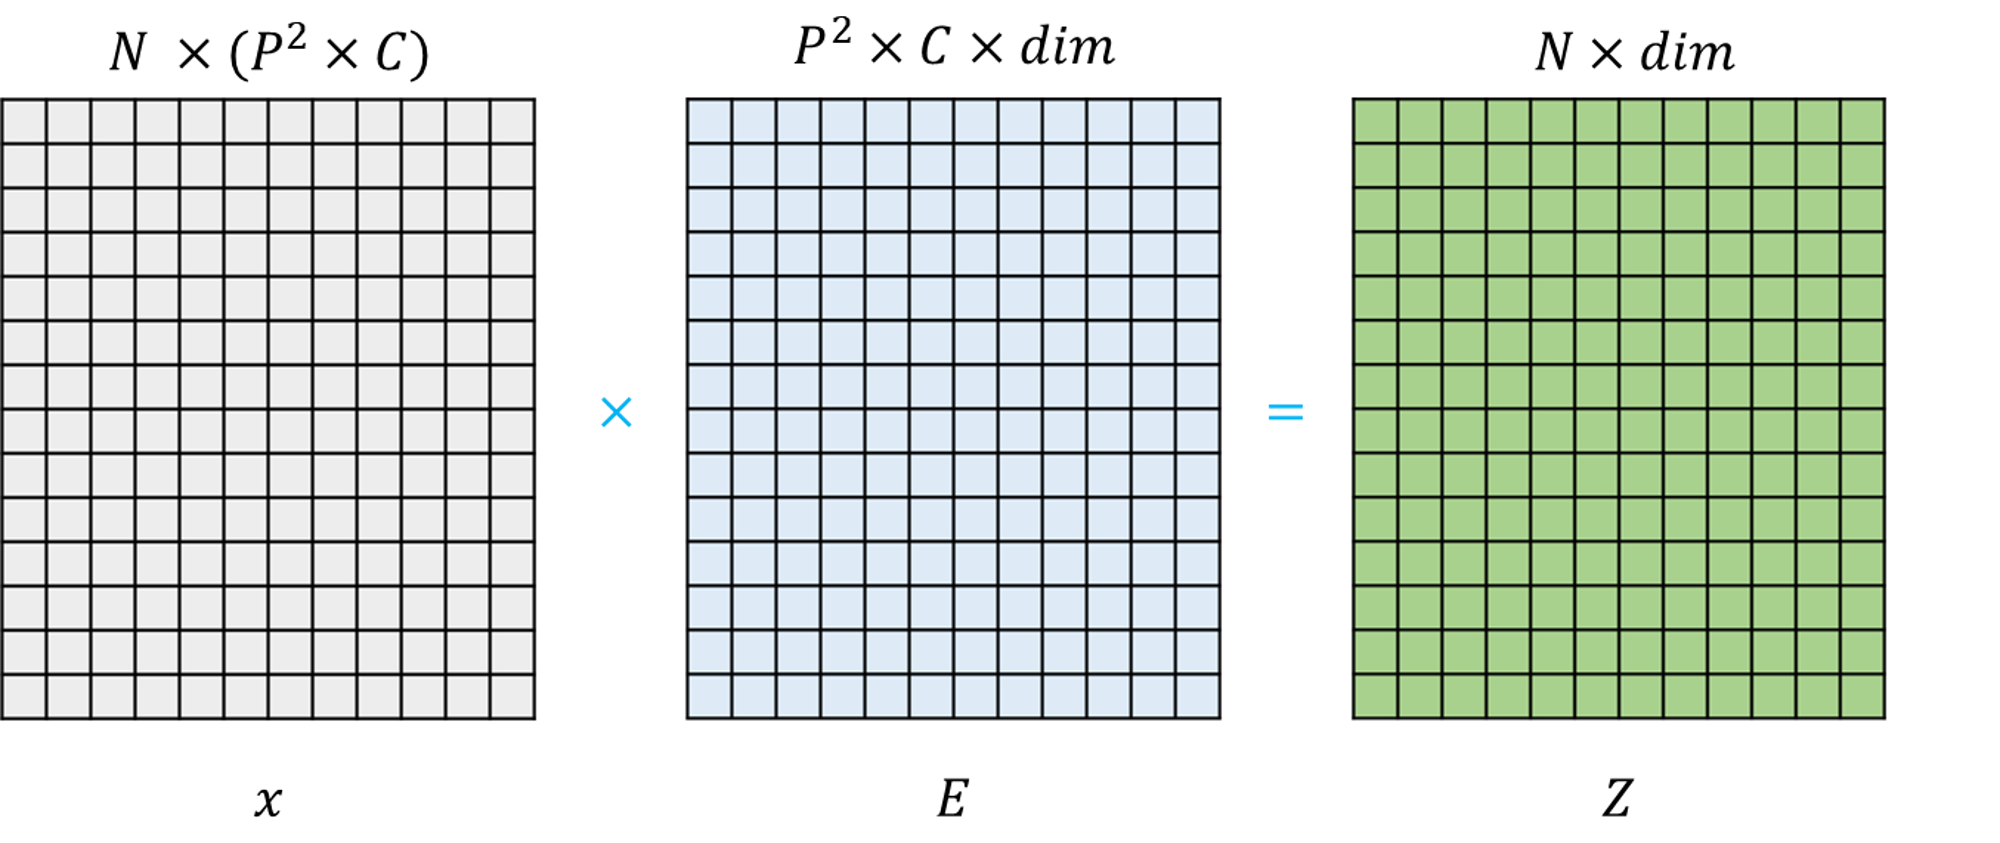
    * (C, H, W) 크기의 이미지를 크기가 (P, P)인 패치 N개로 자른 후, 각각의 패치를 Flatten.
    * N=HW/P² 로 계산되며, 논문에서는 P=14,16,32 를 사용했으며, 이미지 크기 224x224를 표준으로 사용했기 때문에 N=16²,14²,7² 로 계산된다.

#### 👨‍💻 코드 : (2-1)

In [ ]:
class PatchEmbed(nn.Module):
    """ 이미지를 Patch로 나누기 위한 class"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        # Convolution filter와 stride를 이용하여 이미지를 patch화
        #   - filter의 크기 = patch의 크기
        #   - stride = patch의 크기
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

#### 📝 설명 : (2-2)
*  Self-Attention
    * 각 embedded patch token은 Query, Key, Value로 mapping 되도록 학습됨. (Transformer에서의 word token과 동일)
    * Attention Score
        * Query와 Key를 통해 Attention score를 계산
        * Value를 곱함으로써 각각의 Key가 가진 정보를 통합
        * 각 Query를 대표하는 Attention Value를 얻음
    * 각 Head의 Attention score를 종합

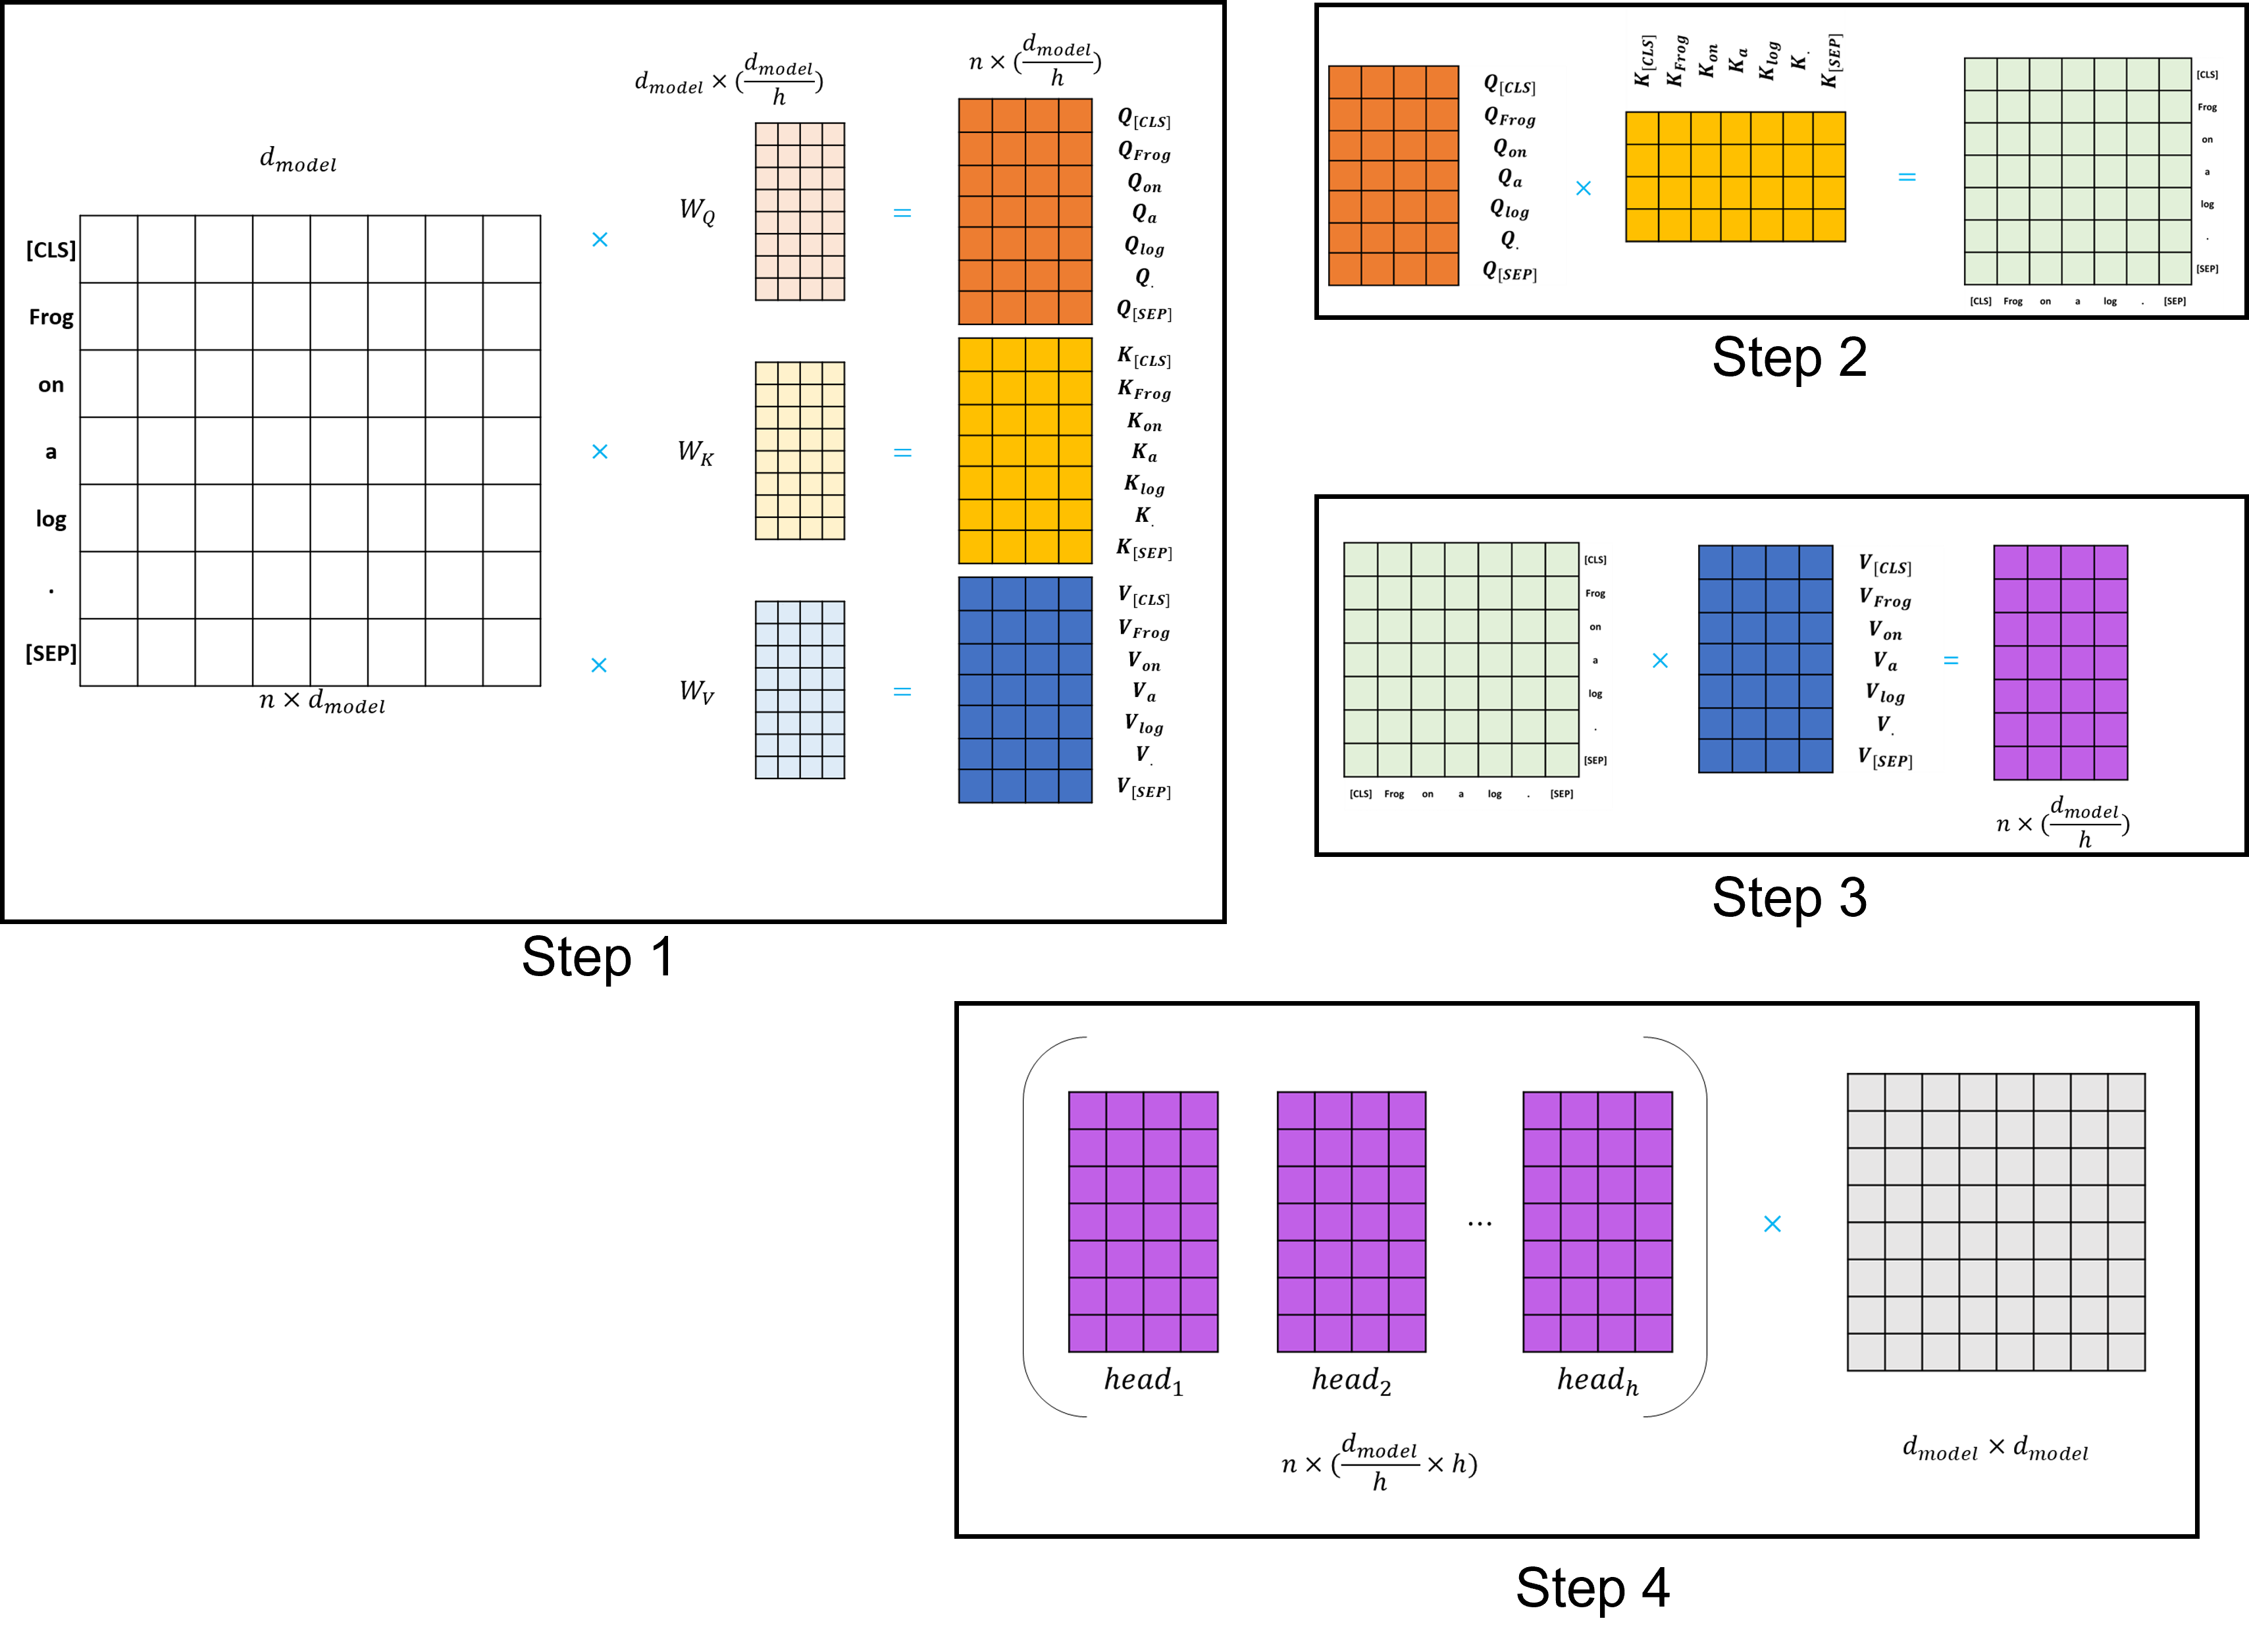

#### 👨‍💻 코드 : (2-2)

In [ ]:
class Attention(nn.Module):
    """Attention 연산을 수행하는 클래스"""

    def __init__(self, dim, num_heads=8, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads

        # Attention score를 계산할 때 softmax의 분모에 해당하는 부분
        self.scale = head_dim ** -0.5

        # Embedding된 token을 각각 Q, K, V로 mapping
        self.qkv = nn.Linear(dim, dim * 3)

        # Attention에 dropout 적용
        self.attn_drop = nn.Dropout(attn_drop)

        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention score 계산 (softmax 부분) 후 dropout 적용
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Value를 반영한 최종 Attention score 계산 후 projection + dropout
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

#### 📝 설명 : (2-3)
*  Transformer encoder block
    * Multi-head attention을 통해 얻은 결과를 Feedforward Network에 통과하는 것을 1개의 Block이라고 한다.
    * 원하는 만큼의 Block을 사용할 수 있다.

#### 👨‍💻 코드 : (2-3)

In [ ]:
class Block(nn.Module):
    """Transformer의 encoder block"""

    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads,  attn_drop=attn_drop, proj_drop=drop
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop
        )

    def forward(self, x):
        """Positional embedding까지 적용된 latent feature를 input으로 받음"""

        # normalization 후 attention score 계산
        y = self.attn(self.norm1(x))
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Dropout과 같이 overfitting을 막기위한 조치, training 단계에서만 적용"""

    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1) # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_() # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class Mlp(nn.Module):
    """Transformer encoder의 feed forward"""
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

## 목차 3
- 3-1 : 데이터 로드 및 전처리
- 3-2 : 학습을 위한 모델 및 목적함수, 옵티마이저 정의
- 3-3 : 모델 학습 (Training)
- 3-4 : 학습한 모델 평가 (Test and Evaluation)


#### 📝 설명 : (3-1)
- torchvision 패키지에서 제공하는 CIFAR10 데이터 다운로드
- CIFAR10 로드 및 전처리 (normalization과 image resizing)
- train 데이터와 test 데이터를 따로 정의하여 DataLoader로 변환
- 학습에서 사용될 batch 크기 정의

#### 👨‍💻 코드 : (3-1)

In [ ]:
# CIFAR10 dataset 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)), # ViT expects images of size 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10의 training, test set 다운로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

#### 📝 설명 : (3-2)
- 사용자 설정에 따라 Custom 모델 또는 HuggingFace에서 제공하는 ViT 모델 로드
- Multi-Class classification을 위한 Cross-entropy loss 정의
- 학습을 위한 Adam optimizer 정의

#### 👨‍💻 코드 : (3-2)

In [ ]:
# model 정의
method = 'custom' # or hugging
pretrain = True

if method == 'custom':
    # 위에서 정의한 ViT 모델
    encoder = vit_small()
    if pretrain:
        state_dict = torch.load("dino_deitsmall16_pretrain.pth")
        encoder.load_state_dict(state_dict)
        model = VisionTransformerWithLinear(encoder).cuda()
    else :
        model = VisionTransformerWithLinear(encoder).cuda()

elif method == 'hugging':
    # huggingface에 준비된 모델
    if pretrain:
        model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10).cuda()
    else:
        model = ViTForImageClassification().cuda()

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 📝 설명 : (3-3)
- 학습을 위한 스크립트 작성
    - 사전 정의된 epoch 만큼 학습하도록 for문 작성
    - Train dataloader로부터 이미지와 label 로드
    - 이미지를 모델에 input 후 그 결과를 cross-entropy loss를 통해 label과 비교
    - optimizer를 이용한 학습 진행
    - 학습 중간마다 train loss 확인

#### 👨‍💻 코드 : (3-3)

In [ ]:
num_epochs = 2

# start training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    cnt = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, labels = data[0].cuda(), data[1].cuda()

        optimizer.zero_grad()

        if method == "custom":
            outputs = model(inputs)
        else:
            outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        cnt += len(inputs)
        if i==10:
            break
    if epoch % 1 == 0:  # print every 5 epochs
        print(f"[Training loss at epoch {epoch + 1}]: {running_loss / len(train_loader):.4f}")

print("Training completed.")

#### 📝 설명 : (3-4)
- Test Dataloader에서 이미지와 label 로드
- 모델에 테스트 데이터 입력 후 output을 정답과 비교하여 정답률 산출

#### 👨‍💻 코드 : (3-4)

In [ ]:
# Evaluation
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    for data in tqdm(test_loader):
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model(images)

        if method == "custom":
            _, predicted = torch.max(outputs, 1)
        else:
            _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        break
print(f'Accuracy on the 10000 test images: {100 * correct / total}%')